In [1]:
pip install finterstellar

In [1]:
import finterstellar as fs

In [2]:
df = fs.fn_single(otp='OTP', symbol='FB', window='T')

In [3]:
df.columns

Index(['Revenue', 'COGS', 'Gross Profit', 'SG&A', 'Operating Income',
       'Net Income', 'EPS', 'EBITDA', 'EBIT', 'Shares', 'Cash & Equivalents',
       'Receivables', 'Current Assets', 'Long Term Assets', 'Total Assets',
       'Current Debt', 'Current Liabilities', 'Long Term Debt',
       'Long Term Liabilities', 'Total Liabilities', 'Shareholders Equity',
       'Depreciation', 'Operating Cash Flow', 'Capital Expenditure',
       'Investing cash flow', 'Dividends', 'Financing cash flow', 'Price'],
      dtype='object')

In [4]:
df['Price'].tail()

2020-06-30   227.07
2020-09-30   261.90
2020-12-31   273.16
2021-03-31   294.53
2021-06-30   347.71
Name: Price, dtype: float64

In [5]:
df['Avg Assets'] = ( df['Total Assets'] + df['Total Assets'].shift(4) ) /2
df['ROA'] = df['Net Income'] / df['Avg Assets']
df['Current Ratio'] = df['Current Assets'] / df['Current Liabilities']
df['Debt/Asset'] = df['Long Term Debt'] / df['Total Assets']
df['Gross Margin'] = df['Gross Profit'] / df['Revenue']
df['Asset Turnover'] = df['Revenue'] / df['Avg Assets']

In [6]:
df['F_ROA'] = 0
df['F_ROA_dt'] = 0
df['F_CFO'] = 0
df['F_Accrual'] = 0
df['F_Liquid'] = 0
df['F_Lever'] = 0
df['F_Shares'] = 0
df['F_Margin'] = 0
df['F_Turn'] = 0
df['F_Score'] = 0

In [7]:
df.loc[df['ROA']>0, 'F_ROA'] = 1
df.loc[df['ROA']>df['ROA'].shift(4), 'F_ROA_dt'] = 1
df.loc[df['Operating Cash Flow']>0, 'F_CFO'] = 1
df.loc[df['Operating Cash Flow']-df['Net Income']>0, 'F_Accrual'] = 1
df.loc[df['Current Ratio']-df['Current Ratio'].shift(4)>0, 'F_Liquid'] = 1
df.loc[df['Debt/Asset']-df['Debt/Asset'].shift(4)<0, 'F_Lever'] = 1
df.loc[df['Shares']-df['Shares'].shift(4)<=0, 'F_Shares'] = 1
df.loc[df['Gross Margin']-df['Gross Margin'].shift(4)>0, 'F_Margin'] = 1
df.loc[df['Asset Turnover']-df['Asset Turnover'].shift(4)>0, 'F_Turn'] = 1
df['F_Score'] = df['F_ROA']+df['F_ROA_dt']+df['F_CFO']+df['F_Accrual']+df['F_Liquid']+df['F_Lever']+df['F_Shares']+df['F_Margin']+df['F_Turn']

In [8]:
print(df[['F_Score', 'F_ROA', 'F_ROA_dt', 'F_CFO', 'F_Accrual', 'F_Liquid', 'F_Lever', 'F_Shares', 'F_Margin', 'F_Turn']].tail())

            F_Score  F_ROA  F_ROA_dt  F_CFO  F_Accrual  F_Liquid  F_Lever  \
2020-06-30        6      1         1      1          1         1        0   
2020-09-30        6      1         1      1          1         1        0   
2020-12-31        7      1         1      1          1         1        1   
2021-03-31        8      1         1      1          1         1        1   
2021-06-30        7      1         1      1          1         0        1   

            F_Shares  F_Margin  F_Turn  
2020-06-30         1         0       0  
2020-09-30         1         0       0  
2020-12-31         1         0       0  
2021-03-31         1         0       1  
2021-06-30         1         0       1  


In [9]:
# Piotroski 준비작업
terms = fs.set_terms(trade_start='2011Q1', trade_end='2021Q1')
data = {}
for t in terms:
    data[t] = fs.fn_consolidated(otp='OTP', term=t, vol=0)
for t in terms:
    prev_t = fs.quarters_before(terms, t, 4)
    data[t]['Market Cap'] = data[t]['Price_M3'] * data[t]['Shares']    
    data[t]['PBR'] = data[t]['Price_M3'] / ( data[t]['Shareholders Equity'] / data[t]['Shares'] )
    data[t]['Avg Assets'] =  ( data[t]['Total Assets'] + data[prev_t]['Total Assets'] ) / 2
    data[t]['ROA'] = data[t]['Net Income'] / data[t]['Avg Assets']
    data[t]['Current Ratio'] = data[t]['Current Assets'] / data[t]['Current Liabilities']
    data[t]['Debt/Asset'] = data[t]['Long Term Debt'] / data[t]['Total Assets']
    data[t]['Gross Margin'] = data[t]['Gross Profit'] / data[t]['Revenue']
    data[t]['Asset Turnover'] = data[t]['Revenue'] / data[t]['Avg Assets']
    
    data[t]['F_ROA'] = 0
    data[t]['F_ROA_dt'] = 0
    data[t]['F_CFO'] = 0
    data[t]['F_Accrual'] = 0
    data[t]['F_Liquid'] = 0
    data[t]['F_Lever'] = 0
    data[t]['F_Shares'] = 0
    data[t]['F_Margin'] = 0
    data[t]['F_Turn'] = 0
    data[t]['F_Score'] = 0
    
    data[t].loc[data[t]['ROA']>0, 'F_ROA'] = 1
    data[t].loc[data[t]['ROA']-data[prev_t]['ROA']>0, 'F_ROA_dt'] = 1
    data[t].loc[data[t]['Operating Cash Flow']>0, 'F_CFO'] = 1
    data[t].loc[data[t]['Operating Cash Flow']-data[t]['Net Income']>0, 'F_Accrual'] = 1
    data[t].loc[data[t]['Current Ratio']-data[prev_t]['Current Ratio']>0, 'F_Liquid'] = 1
    data[t].loc[data[t]['Debt/Asset']-data[prev_t]['Debt/Asset']<0, 'F_Lever'] = 1
    data[t].loc[data[t]['Shares']-data[prev_t]['Shares']<=0, 'F_Shares'] = 1
    data[t].loc[data[t]['Gross Margin']-data[prev_t]['Gross Margin']>0, 'F_Margin'] = 1
    data[t].loc[data[t]['Asset Turnover']-data[prev_t]['Asset Turnover']>0, 'F_Turn'] = 1
    data[t]['F_Score'] = data[t]['F_ROA']+data[t]['F_ROA_dt']+data[t]['F_CFO']+data[t]['F_Accrual']+data[t]['F_Liquid']+data[t]['F_Lever']+data[t]['F_Shares']+data[t]['F_Margin']+data[t]['F_Turn']

2010Q4...OK
2011Q1...OK
2011Q2...OK
2011Q3...OK
2011Q4...OK
2012Q1...OK
2012Q2...OK
2012Q3...OK
2012Q4...OK
2013Q1...OK
2013Q2...OK
2013Q3...OK
2013Q4...OK
2014Q1...OK
2014Q2...OK
2014Q3...OK
2014Q4...OK
2015Q1...OK
2015Q2...OK
2015Q3...OK
2015Q4...OK
2016Q1...OK
2016Q2...OK
2016Q3...OK
2016Q4...OK
2017Q1...OK
2017Q2...OK
2017Q3...OK
2017Q4...OK
2018Q1...OK
2018Q2...OK
2018Q3...OK
2018Q4...OK
2019Q1...OK
2019Q2...OK
2019Q3...OK
2019Q4...OK
2020Q1...OK
2020Q2...OK
2020Q3...OK
2020Q4...OK


In [10]:
# High F-Score
s1 = {}
s2 = {}
s3 = {}
s = {}
signal = {}
for t in terms:
    s1[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True)
    s2[t] = fs.fn_filter(data[t], by='PBR', floor=.1, cap=1, asc=True)
    s3[t] = fs.fn_filter(data[t], by='F_Score', floor=7, cap=9, asc=False)
    s[t] = fs.combine_signal(s1[t], s2[t], s3[t]).sample(frac=1)[:30]
    signal[t] = list(s[t].index)
df = fs.backtest(signal=signal, data=data, m=3, cost=.001)

CAGR: 26.32%
Accumulated return: 936.55%
Investment period: 10.0yrs
Sharpe ratio: 2.62
MDD: -23.83%


In [11]:
# Mid F-Score
s1 = {}
s2 = {}
s3 = {}
s = {}
signal = {}
for t in terms:
    s1[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True)
    s2[t] = fs.fn_filter(data[t], by='PBR', floor=.1, cap=1, asc=True)
    s3[t] = fs.fn_filter(data[t], by='F_Score', floor=4, cap=6, asc=False)
    s[t] = fs.combine_signal(s1[t], s2[t], s3[t]).sample(frac=1)[:30]
    signal[t] = list(s[t].index)
df = fs.backtest(signal=signal, data=data, m=3, cost=.001)

CAGR: 18.53%
Accumulated return: 448.03%
Investment period: 10.0yrs
Sharpe ratio: 1.41
MDD: -42.42%


In [12]:
# Low F-Score
s1 = {}
s2 = {}
s3 = {}
s = {}
signal = {}
for t in terms:
    s1[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True)
    s2[t] = fs.fn_filter(data[t], by='PBR', floor=.1, cap=1, asc=True)
    s3[t] = fs.fn_filter(data[t], by='F_Score', floor=0, cap=3, asc=False)
    s[t] = fs.combine_signal(s1[t], s2[t], s3[t]).sample(frac=1)[:30]
    signal[t] = list(s[t].index)
df = fs.backtest(signal=signal, data=data, m=3, cost=.001)

CAGR: 13.55%
Accumulated return: 256.76%
Investment period: 10.0yrs
Sharpe ratio: 0.66
MDD: -54.15%


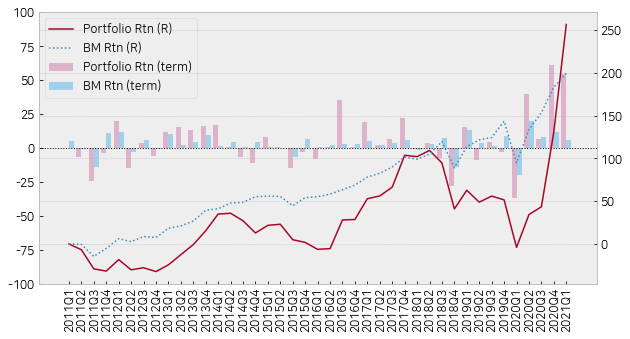

In [13]:
fs.draw_return(df)

In [15]:
for p in range(1,8,3):
    print('=== {}~{} ==='.format(p, p+2))
    s1 = {}
    s2 = {}
    s = {}
    signal = {}
    prev_t = terms[0]
    for t in terms[1:]:    
        s1[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True)
        s2[t] = fs.fn_filter(data[t], by='PBR', floor=.1, cap=1, asc=True)
        s3[t] = fs.fn_filter(data[t], by='F_Score', floor=p, cap=p+2, asc=False)
        s[t] = fs.combine_signal(s1[t], s2[t], s3[t]).sample(frac=1)[:30]
        signal[t] = list(s[t].index)
    df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
    print(len(s1[t]), len(s2[t]), len(s3[t]), len(s[t]))

=== 1~3 ===
CAGR: 22.86%
Accumulated return: 645.48%
Investment period: 9.8yrs
Sharpe ratio: 1.71
MDD: -47.38%
1000 612 1266 30
=== 4~6 ===
CAGR: 24.55%
Accumulated return: 752.00%
Investment period: 9.8yrs
Sharpe ratio: 2.79
MDD: -20.41%
1000 612 2322 30
=== 7~9 ===
CAGR: 22.92%
Accumulated return: 648.98%
Investment period: 9.8yrs
Sharpe ratio: 2.82
MDD: -24.01%
1000 612 524 26
